In [1]:
import glob
import csv
from tqdm.notebook import tqdm
import numpy as np
import functools

from utils.featurize import normalize, t_featurize, select_features
from utils.symbolic import get_all_logprobs, get_exp_featurize, backtrack_functions
from utils.load import Dataset, get_generate_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import pickle
import random
import plotly.express as px
import torch
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os
%matplotlib inline

/Users/leo/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/leo/.pyenv/versions/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
exp_to_data = pickle.load(open("symbolic_data_baseline", "rb"))
t_data = pickle.load(open("t_data_baseline", "rb"))

exp_to_data_eval = pickle.load(open("symbolic_data_eval", "rb"))
t_data_eval = pickle.load(open("t_data_eval", "rb"))

In [3]:
def get_featurized_data(best_features, gpt_only=False):
    gpt_data = np.concatenate(
        [t_data] + [exp_to_data[i] for i in best_features if i in exp_to_data.keys()], axis=1
    )
    if gpt_only:
        return gpt_data

    eval_data = np.concatenate(
        [t_data_eval] + [exp_to_data_eval[i] for i in best_features], axis=1
    )
    return np.concatenate([gpt_data, eval_data], axis=0)

In [4]:
def get_featurized_aug(best_features, aug_t_data, aug_exp, gpt_only=False):
    gpt_data = np.concatenate(
        [aug_t_data] + [aug_exp[i] for i in best_features if i in aug_exp.keys()], axis=1
    )

    return gpt_data

# Data loading

In [5]:
file_retriever = lambda past, model: past + glob.glob(f"{base_path}/{model}/*.txt")
base_path = "data/essay"

In [6]:
train_models = ["human", "gpt"]
train_files = sorted(functools.reduce(file_retriever, train_models, []), key=lambda x: int(x.split("/")[-1].split(".")[0]))

In [7]:
test_models = ["gpt_prompt1", "gpt_prompt2", "gpt_semantic", "gpt_writing", "claude"]
test_files = sorted(functools.reduce(file_retriever, test_models, []), key=lambda x: int(x.split("/")[-1].split(".")[0]))

In [8]:
print(f"Num train: {len(train_files)}")
print(f"Num test: {len(test_files)}")

Num train: 1988
Num test: 4970


In [9]:
all_files = train_files + test_files
print(f"All files length: {len(all_files)}")

All files length: 6958


# Splitting Data

In [10]:
class config:
    p = 0.5

In [11]:
train_labels = np.array(["human" not in file for file in train_files]).astype(int)
test_labels = np.array(["human" not in file for file in test_files]).astype(int)
all_labels = np.concatenate((train_labels, test_labels))

print(f"All labels length: {len(all_labels)}")

All labels length: 6958


In [12]:
other_test_indices = np.arange(len(all_labels))[1988:]
augmentations = ["baseline", "synonym", "back", "emotion", "style", "summary"]
train_sizes = [10, 25, 50, 75, 100]
seeds = [51, 53, 62, 67, 77, 78, 93, 97]
score_dict = {}

**************** SEED 51 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 275.12it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 238.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8745725113226731

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.82it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9589539314166955

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.74it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9794238683127572

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.53it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.85it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.992024435771254

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.05it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-len, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 204.32it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9790593889461037

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.74it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.9127138070886969

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.53it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.913441493700716

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.87it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.954398249452954

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-< davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.16it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9356944817100439

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.92it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9673145646300009

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.87it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.9483615533653441

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.73it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.50it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.8763476141370582

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.91it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9450510743219444

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-< davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9790916880891174

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.21it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9482269503546099

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.20it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.9134548002803083

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.73it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9316781280700187

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.98it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9553961868112647

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-< davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.17it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9626722483865341

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.80it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.07it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9495254147077087

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.41it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8995547640249332

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.42it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9330851723832314

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9551636395542686

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-< davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9474709894587652

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.32it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9434534427399215

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.9137459168358789

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.05it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9107338444687842

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.28it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9432068327903496

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-< davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9187176459903733

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.86it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.40it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9597892888498684

passes...


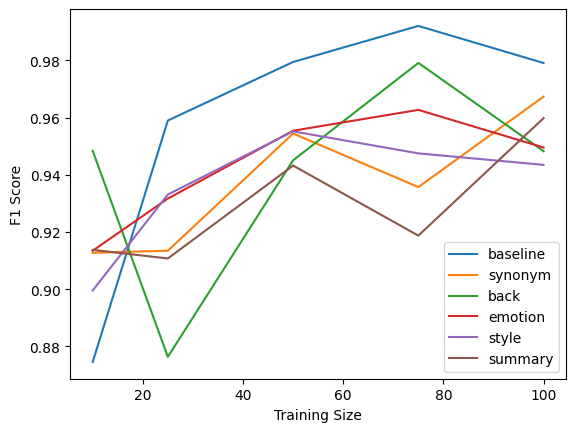

**************** SEED 53 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.91it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.7395471300684571

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.35it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9460529789668222

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.42it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-add davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 203.55it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-add davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.966241430183112

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.98it/s]


Iteration 1, Current Score: 0.9866666667,                 Best Feature: davinci-logprobs s-len, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 208.41it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9936413734633319

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.45it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9883414177516807

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.621191135734072

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.75it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9697335517806329

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.94it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.19it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9760963026655202

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.64it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.02it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9626585045911674

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.74it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9639734172787688

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.48007131032726347

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.82it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9766843819646837

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9832011597168926

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.50it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9571026722925458

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.68it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.27it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9656858465030996

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.47723504655018495

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.17it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.94it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9808873720136518

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9757273196763643

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.99it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9509994693083319

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.23it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9562764456981664

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.6504799548277809

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.53it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9399839957321953

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.37it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9514409094914955

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.74it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9335730337078652

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.16it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9510316125033207

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.41it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.41it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.4651581383389046

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.13it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9398916807244961

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.89it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9760382024388164

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.87it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9457970499377999

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.35it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.88it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9675901725039205

passes...


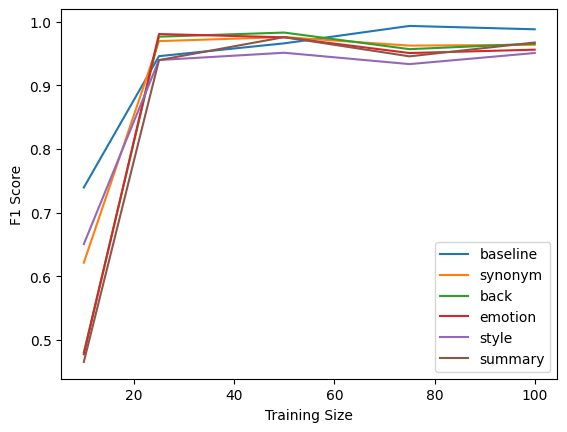

**************** SEED 62 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.77it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8583295711060948

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9507651945780499

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.99561846983485

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.35it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.70it/s]


Iteration 1, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 201.26it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.989441416893733

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.50it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9883334752618581

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.71it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8374711582833411

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.76it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.812077870480731

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9736955584303579

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.05it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.53it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9325660852364682

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.65it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 186.82it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9518243003896564

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.15it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.8274064420033513

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.51it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.28it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.8017638805371818

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.17it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9742041238892244

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.56it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.8753199962074524

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.49it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 187.45it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9478083044367387

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.86it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.96it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8089738735327527

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.8643196955280685

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.969429288992812

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9259326331039478

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.52it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 187.09it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9498802448327863

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.20it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.860182096817813

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.54it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.887188578893347

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.02it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.62it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9512646514497224

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9059734513274337

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.62it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 187.37it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9385964912280702

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.9041870023118418

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.84it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.831636648394675

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.31it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.12it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9554073033707865

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.43it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.817167894841665

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 201.03it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 181.38it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9457847413869848

passes...


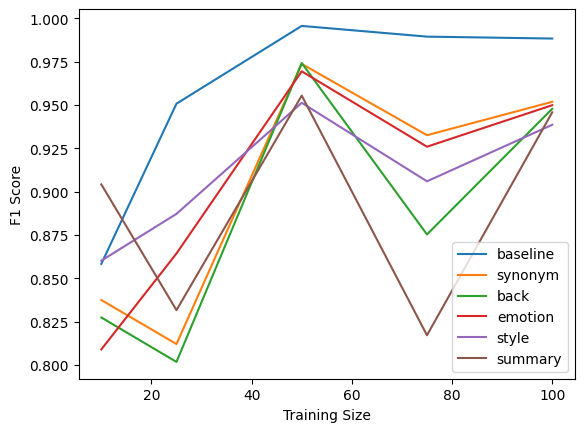

**************** SEED 67 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.14it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.62it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8098099084014577

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.63it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9374944899938288

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.13it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.62it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9725118483412323

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.34it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.00it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9923586347427407

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 197.63it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9584647739221872

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.69it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.7835344215755855

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.85it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.8480725623582767

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< ada-logprobs v-add davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.57it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.8927380511300481

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.75it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9733333333


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.21it/s]


Iteration 1, Current Score: 0.9733333333,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 191.77it/s]


Iteration 2, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-mul davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2531/2531 [00:12<00:00, 196.00it/s]


Iteration 3, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.8914446002805049

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.44it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.8735260555344238

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.95it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.783218203982121

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.59it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.00it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.7540476436011138

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< ada-logprobs v-add davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.8816318892111912

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9733333333


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.26it/s]


Iteration 1, Current Score: 0.9733333333,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 195.41it/s]


Iteration 2, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-mul davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2531/2531 [00:12<00:00, 198.59it/s]


Iteration 3, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.8692916388597578

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 244.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 201.40it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.8717509283061983

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.6268896014658727

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.24it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.7780810838135679

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< ada-logprobs v-add davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.890893870337643

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9733333333


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.81it/s]


Iteration 1, Current Score: 0.9733333333,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 192.51it/s]


Iteration 2, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-mul davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2531/2531 [00:12<00:00, 196.85it/s]


Iteration 3, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.8846660395108185

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.82it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.86it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.8747745181809551

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.29it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.15it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.64104013566987

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.52it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.7849473156046162

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< ada-logprobs v-add davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.06it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9368505195843325

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.86it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9733333333


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 196.57it/s]


Iteration 1, Current Score: 0.9733333333,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 188.87it/s]


Iteration 2, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-mul davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2531/2531 [00:13<00:00, 192.83it/s]


Iteration 3, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.8288590604026845

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:13<00:00, 194.19it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.8785754877817769

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.73it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.6228080229226362

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 240.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.75it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.7481672689726381

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 242.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< ada-logprobs v-add davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.12it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.8696889226100152

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9733333333


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 197.97it/s]


Iteration 1, Current Score: 0.9733333333,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2532/2532 [00:13<00:00, 190.79it/s]


Iteration 2, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-mul davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2531/2531 [00:12<00:00, 195.50it/s]


Iteration 3, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.8953889147647881

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 240.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 201.67it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9036968576709796

passes...


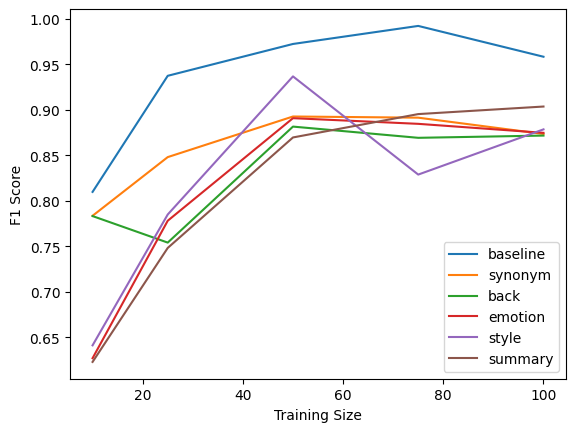

**************** SEED 77 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.13it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8301996510951735

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9401799894123875

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.60it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9865988125530111

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.60it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9867098313170898

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.87it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.21it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9820554649265906

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.06it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.6237771895500057

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.973219667613881

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.18it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9330944917151813

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9445136048372754

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.25it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.45it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9243194192377495

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.71it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.7245731254639941

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.69it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9748087008855645

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.52it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9513589585715543

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:13<00:00, 193.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9162633549447539

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.51it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 196.01it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.913410383415887

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.29it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.6653434777814533

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.02it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9572440325260121

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9389537474378398

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.30it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9462461128387384

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.79it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9341252699784017

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.68it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.6417353971302677

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.02it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9163346613545816

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.80it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.47it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9467162329615861

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.52it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.43it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9527677231394014

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 201.73it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9376625706341376

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.40it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.6743261157755193

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.20it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9593170136771496

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.00it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9430272864634255

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 200.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9242753623188406

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.17it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 198.10it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9357880556802873

passes...


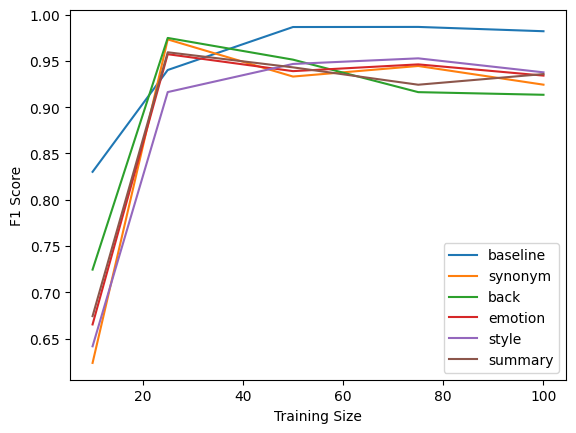

**************** SEED 78 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.64it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.42it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.7894736842105263

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.04it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9415988092111024

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9766363167840577

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.49it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9851129363449692

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.74it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9817558886509636

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.95it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.43it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8076161749458007

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.28it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 211.05it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.8906438725262473

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.13it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9353482965215059

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.01it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9611412567827762

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9678092918044197

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.31it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.8215061549601738

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.8994942528735632

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9394047406879344

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.57it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.79it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9514391665195127

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.41it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.34it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9330212459488657

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.58it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.16it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8027363883422359

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.99it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9114682647779897

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.22it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9303076509103956

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.31it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9611548556430446

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.60it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9695757997218358

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8358638037912137

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.99it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9098017821422076

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.32it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9075553107500229

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 242.75it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 197.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9528343471744688

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 237.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 198.16it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9656734622756578

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.7403048427551611

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 242.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.65it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9145028499050032

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.42it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9263328530259366

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.73it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.06it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9223089489925577

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.59it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9623928633898898

passes...


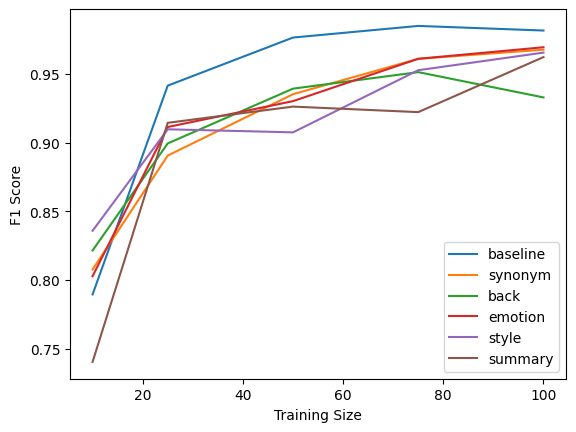

**************** SEED 93 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8980957282552754

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.08it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9543755974624142

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.66it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.71it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9881235154394299

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 242.87it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9878328937292606

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 202.41it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9920081618772317

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.85it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8781849912739965

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.95it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9698483804272915

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9725530813050233

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.62it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9451896597672559

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 244.52it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.82it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9455582286376192

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.80it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.45it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.904916353704336

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.63it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9619923637625825

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.96it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9592799720377491

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.00it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 211.05it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9068825910931174

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.28it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.55it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9310812031433475

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.73it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8540403583386119

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.42it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.976902752919117

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.79it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9393831342485292

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:13<00:00, 194.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9592355571140527

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.48it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9233988355167394

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.47it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8859375

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.72it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.20it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9817561807331628

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9235485034258926

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 231.54it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9562236286919831

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.86it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.13it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9134465351078477

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.8818253069755291

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 244.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.43it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9826442062276671

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.59it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.30it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.931958762886598

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.91it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9056777399466274

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 242.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9525915443127543

passes...


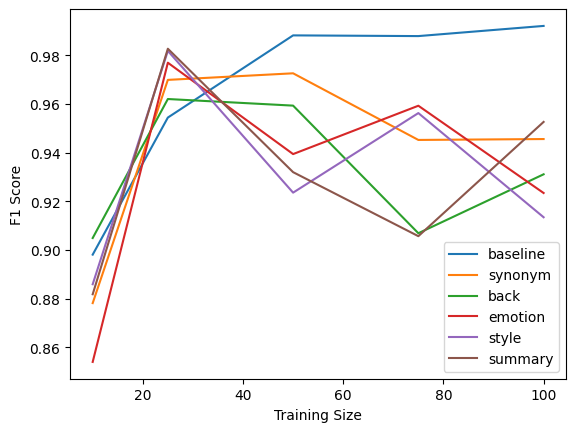

**************** SEED 97 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.6836723474436504

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.60it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9403037179263397

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.63it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9880579317354112

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 200.07it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9822789144765003

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 241.72it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 196.44it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 199.43it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9915708812260536

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.6492394366197183

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.58it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9103485937926641

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.01it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9595124074880279

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.54it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 198.84it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9344453412250022

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 194.86it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9683604985618408

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.25it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.63it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.46585209003215433

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.57it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9582429030297769

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.52it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9547361062565537

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 200.79it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9263443289652056

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 235.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 200.59it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9413342872473618

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.95it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.57it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.573341303048416

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9097215883158375

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9378782484870061

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 239.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.50it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9234675371780922

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 235.19it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 197.48it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9508022338445173

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.51it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.45584045584045585

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.73it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9272939696234385

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.23it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9586086956521739

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 232.59it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 197.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.918648082354013

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.02it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9435073627844712

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.77it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.74914516630401

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.52it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.78it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.8908759124087591

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.04it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9644214162348878

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 240.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 200.22it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9192185370286233

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 198.65it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9473684210526315

passes...


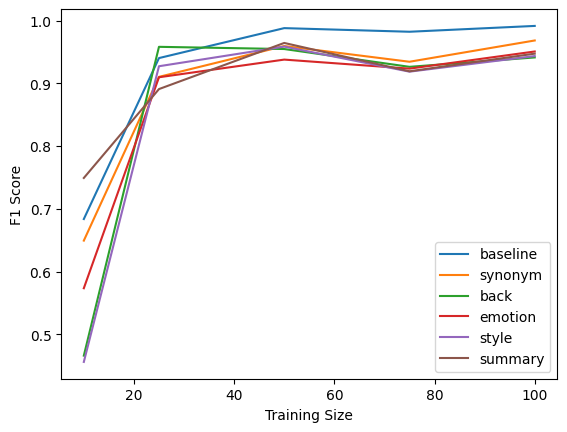

In [13]:
for seed in seeds:
    early_stop = False
    print(f"**************** SEED {seed} ****************")
    for aug in augmentations:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        scores = []
        if early_stop:
            print("early stopping")
            break
        print(f"***************** AUGMENTATION: {aug} *****************")
        for size in tqdm(train_sizes):
            print(f"***************** TRAIN SIZE: {size} *****************")
            train_indices, test_indices, _, _ = train_test_split(
                np.arange(len(train_files)),
                train_labels,
                train_size = size,
                stratify = train_labels
            )
            
            all_test_indices = np.concatenate((test_indices, other_test_indices))
        
            curr_best_features = select_features(
                exp_to_data,
                train_labels,
                verbose=True,
                to_normalize = True,
                indices = train_indices
            )
        
            data = normalize(get_featurized_data(curr_best_features))
            model = LogisticRegression()
            
            if aug != "baseline":
                print(f"TRAINING WITH {aug} AUGMENTED DATA.")
                t_data_aug = pickle.load(open(f"t_data_{aug}", "rb"))
                exp_to_data_aug = pickle.load(open(f"symbolic_data_{aug}", "rb"))
                
                aug_data = normalize(get_featurized_aug(curr_best_features, t_data_aug, exp_to_data_aug))
                aug_indices = np.random.choice(train_indices, size = int(len(train_indices) * config.p))
                
                y = np.concatenate((all_labels[train_indices], all_labels[aug_indices])) # Duplicate training labels
                X = np.concatenate((data[train_indices], aug_data[aug_indices])) # Appending augmented data to original data
            else:
                print("TRAINING WITHOUT AUGMENTATIONS")
                y = all_labels[train_indices]
                X = data[train_indices]
        
            model.fit(X, y)
            
            score = f1_score(all_labels[all_test_indices], model.predict(data[all_test_indices]))
            
            print(f"Train size: {size}")
            print(f"F1-Score: {score}")
            print()
            if aug == "baseline" and ((size == 10 and score > 0.91) or (size == 25 and score > 0.96)):
                print("early stopping.")
                early_stop = True
                break
            else:
                print("passes...")
            scores.append(score)
    
        score_dict[aug] = scores
        
    if not early_stop:
        if not os.path.exists(f"experiments/50-percent/{seed}"):
            os.makedirs(f"experiments/50-percent/{seed}")
            
        for experiment, values in score_dict.items():
            plt.plot(train_sizes, values, label = experiment)
        
        plt.legend()
        plt.xlabel("Training Size")
        plt.ylabel("F1 Score")
        plt.savefig(f"experiments/50-percent/{seed}/results.png")
        plt.show()
    
        with open(f'experiments/50-percent/{seed}/results.pickle', 'wb') as handle:
            pickle.dump(score_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)